In [ ]:
# Core Python utilities
import os
import re
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    GRU,
    Bidirectional,
    Dense,
    Dropout,
    GlobalAveragePooling1D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# NLP Utilities
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow Hub
import tensorflow_hub as hub
import tensorflow_text as text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Credit_Complaint_ML/complaints.csv')


In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,09/04/12,Bank account or service,(CD) Certificate of deposit,"Account opening, closing, or management",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",WA,98006,NaN,NaN,Referral,09/05/12,Closed with non-monetary relief,Yes,No,146222
1,07/24/13,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,HSBC NORTH AMERICA HOLDINGS INC.,CA,90017,NaN,NaN,Postal mail,07/25/13,Closed with explanation,Yes,No,465453
2,10/14/15,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22204,Older American,NaN,Postal mail,10/21/15,Closed with explanation,Yes,Yes,1605896
3,10/06/16,Bank account or service,Checking account,Using a debit or ATM card,NaN,I have an account in Texas. Citi sent me a new...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,75078,Servicemember,Consent provided,Web,10/06/16,Closed with explanation,Yes,No,2147451
4,05/19/16,Bank account or service,Checking account,Problems caused by my funds being low,NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10003,NaN,Consent not provided,Web,05/19/16,Closed with monetary relief,Yes,No,1933031


In [ ]:
cols_to_drop = [
    'Date received',
    'Company public response',
    'State',
    'ZIP code',
    'Tags',
    'Consumer consent provided?',
    'Submitted via',
    'Date sent to company',
    'Complaint ID',
    'Product',
    'Sub-issue',
    'Company'
]

df = df.drop(columns=cols_to_drop)



In [ ]:
df.head()


,Sub-product,Issue,Consumer complaint narrative,Company response to consumer,Timely response?,Consumer disputed?
0,(CD) Certificate of deposit,"Account opening, closing, or management",NaN,Closed with non-monetary relief,Yes,No
1,Checking account,"Account opening, closing, or management",NaN,Closed with explanation,Yes,No
2,Checking account,"Account opening, closing, or management",NaN,Closed with explanation,Yes,Yes
3,Checking account,Using a debit or ATM card,I have an account in Texas. Citi sent me a new...,Closed with explanation,Yes,No
4,Checking account,Problems caused by my funds being low,NaN,Closed with monetary relief,Yes,No


In [ ]:
df.shape


(86204, 6)

In [ ]:
df.isnull().sum()


,0
Sub-product,0
Issue,0
Consumer complaint narrative,71320
Company response to consumer,0
Timely response?,0
Consumer disputed?,0


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(14884, 6)

In [ ]:
df.head()

,Sub-product,Issue,Consumer complaint narrative,Company response to consumer,Timely response?,Consumer disputed?
3,Checking account,Using a debit or ATM card,I have an account in Texas. Citi sent me a new...,Closed with explanation,Yes,No
6,Checking account,"Account opening, closing, or management",On XXXX XXXX 2015 I called Santander bank and ...,Closed,Yes,No
12,Checking account,Using a debit or ATM card,There was an erroneous charge on my TD bank ac...,Closed with monetary relief,Yes,No
14,Checking account,"Account opening, closing, or management","Dear Sir/Madam, Around six months ago I opened...",Closed with non-monetary relief,Yes,No
20,Checking account,Problems caused by my funds being low,I had a check bounce due to insufficient funds...,Closed with explanation,Yes,No


In [ ]:
columns_to_check = [
    'Sub-product',
    'Issue',
    'Company response to consumer',
    'Timely response?',
    'Consumer disputed?'
]

for col in columns_to_check:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())



Unique values in 'Sub-product':
['Checking account' 'Other bank product/service' 'Savings account'
 'Cashing a check without an account' '(CD) Certificate of deposit']

Unique values in 'Issue':
['Using a debit or ATM card' 'Account opening, closing, or management'
 'Problems caused by my funds being low' 'Deposits and withdrawals'
 'Making/receiving payments, sending money']

Unique values in 'Company response to consumer':
['Closed with explanation' 'Closed' 'Closed with monetary relief'
 'Closed with non-monetary relief']

Unique values in 'Timely response?':
['Yes' 'No']

Unique values in 'Consumer disputed?':
['No' 'Yes']


In [ ]:
df.head(10)

,Sub-product,Issue,Consumer complaint narrative,Company response to consumer,Timely response?,Consumer disputed?
3,Checking account,Using a debit or ATM card,I have an account in Texas. Citi sent me a new...,Closed with explanation,Yes,No
6,Checking account,"Account opening, closing, or management",On XXXX XXXX 2015 I called Santander bank and ...,Closed,Yes,No
12,Checking account,Using a debit or ATM card,There was an erroneous charge on my TD bank ac...,Closed with monetary relief,Yes,No
14,Checking account,"Account opening, closing, or management","Dear Sir/Madam, Around six months ago I opened...",Closed with non-monetary relief,Yes,No
20,Checking account,Problems caused by my funds being low,I had a check bounce due to insufficient funds...,Closed with explanation,Yes,No
26,Other bank product/service,Deposits and withdrawals,I was applying for a XXXX job on XXXX on XXXX ...,Closed with explanation,Yes,No
32,Checking account,"Account opening, closing, or management",This is a follow-up to Case number : XXXX. I d...,Closed with monetary relief,Yes,No
33,Checking account,Using a debit or ATM card,When monitoring my checking account online som...,Closed with monetary relief,Yes,No
35,Checking account,"Account opening, closing, or management",I signed up for an HSBC Checking acc ount whi...,Closed with explanation,Yes,No
41,Other bank product/service,"Making/receiving payments, sending money","Back on 2005, We refinanced our home loan with...",Closed with explanation,Yes,No


In [ ]:
# Reset index in place
df.reset_index(drop=True, inplace=True)



Labeling

In [ ]:
import tensorflow_hub as hub
import tensorflow_text
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load USE model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Batched embedding function to avoid crashes
def get_embeddings_batched(texts, batch_size=256):
    vectors = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        vec = embed(batch).numpy()
        vectors.append(vec)
    return np.vstack(vectors)

# Extract text data
texts = df["Consumer complaint narrative"].astype(str).tolist()

# Generate embeddings
print("Generating embeddings in batches...")
embeddings = get_embeddings_batched(texts)

# Encode metadata
meta_cols = ["Sub-product", "Issue", "Company response to consumer",
             "Timely response?", "Consumer disputed?"]
metadata = pd.get_dummies(df[meta_cols], drop_first=True).astype(float)

# Combine embeddings and metadata
combined = np.hstack([embeddings, metadata.values])

# Scale all features
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined)

# KMeans clustering into 3 severity levels
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(combined_scaled)
df["Cluster"] = clusters

# Compute complaint length for severity mapping
df["length"] = df["Consumer complaint narrative"].str.split().str.len()

# Rank clusters by complaint length (longer = more severe)
cluster_stats = df.groupby("Cluster").agg(avg_length=("length", "mean"))
cluster_stats["severity_rank"] = cluster_stats["avg_length"].rank()

# Map clusters to Low/Medium/High
sorted_clusters = cluster_stats.sort_values("severity_rank").index.tolist()
severity_map = {
    sorted_clusters[0]: "Low",
    sorted_clusters[1]: "Medium",
    sorted_clusters[2]: "High"
}
df["Severity"] = df["Cluster"].map(severity_map)

# Map severity to numeric labels
severity_to_label = {"Low": 0, "Medium": 1, "High": 2}
df["Severity_label"] = df["Severity"].map(severity_to_label)

# Preview results
print(df[["Consumer complaint narrative", "Severity", "Severity_label"]].head())


Generating embeddings in batches...
                        Consumer complaint narrative Severity  Severity_label
0  I have an account in Texas. Citi sent me a new...      Low               0
1  On XXXX XXXX 2015 I called Santander bank and ...     High               2
2  There was an erroneous charge on my TD bank ac...      Low               0
3  Dear Sir/Madam, Around six months ago I opened...   Medium               1
4  I had a check bounce due to insufficient funds...      Low               0


In [ ]:
df = df.drop(columns=["Cluster", "length"])


In [ ]:
df.head(5)

,Sub-product,Issue,Consumer complaint narrative,Company response to consumer,Timely response?,Consumer disputed?,Severity,Severity_label
0,Checking account,Using a debit or ATM card,I have an account in Texas. Citi sent me a new...,Closed with explanation,Yes,No,Low,0
1,Checking account,"Account opening, closing, or management",On XXXX XXXX 2015 I called Santander bank and ...,Closed,Yes,No,High,2
2,Checking account,Using a debit or ATM card,There was an erroneous charge on my TD bank ac...,Closed with monetary relief,Yes,No,Low,0
3,Checking account,"Account opening, closing, or management","Dear Sir/Madam, Around six months ago I opened...",Closed with non-monetary relief,Yes,No,Medium,1
4,Checking account,Problems caused by my funds being low,I had a check bounce due to insufficient funds...,Closed with explanation,Yes,No,Low,0


# Exploratory Data Analysis

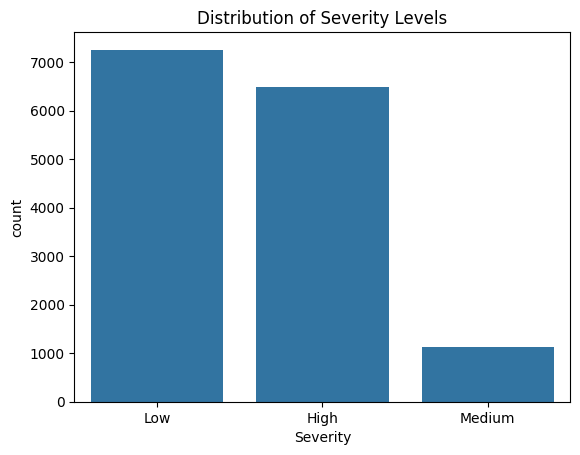

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Severity', data=df)
plt.title("Distribution of Severity Levels")
plt.show()


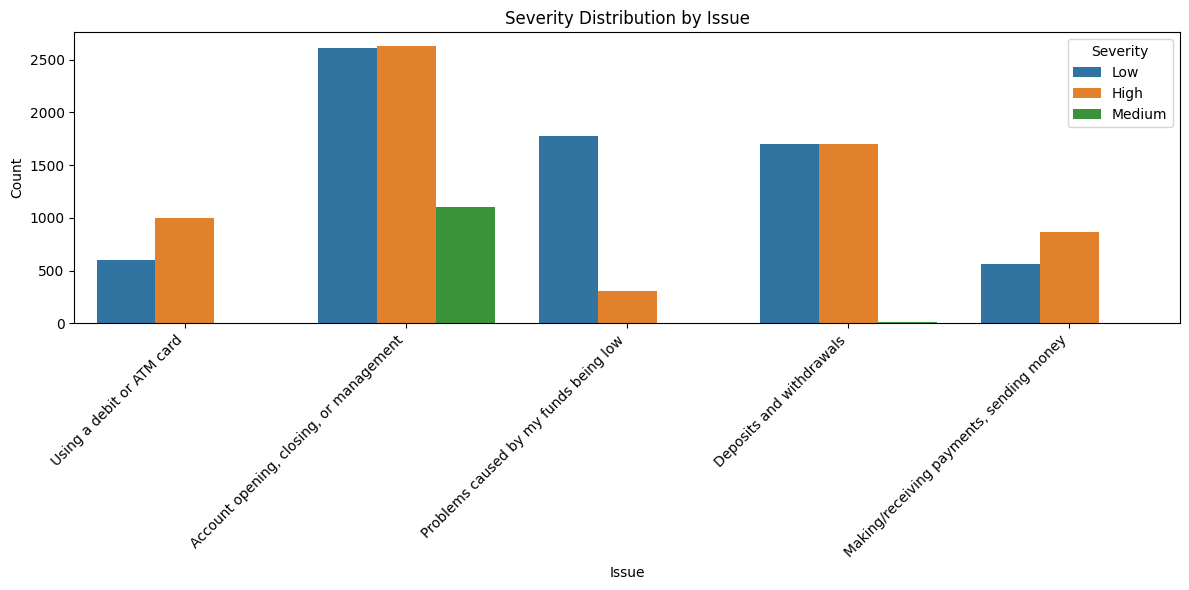

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))  # Make the figure wider
sns.countplot(x='Issue', hue='Severity', data=df)

# Rotate x-axis labels and align them
plt.xticks(rotation=45, ha='right')  # 'ha' is horizontal alignment
plt.title("Severity Distribution by Issue")
plt.xlabel("Issue")
plt.ylabel("Count")
plt.tight_layout()  # Adjust layout so nothing is cut off
plt.show()


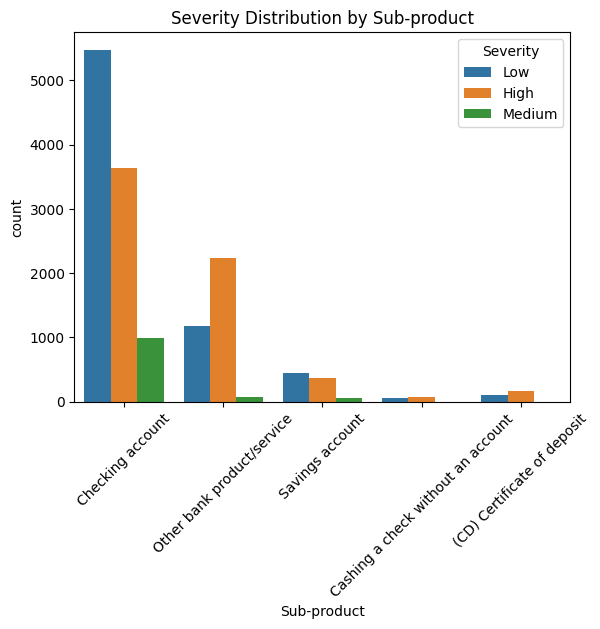

In [ ]:
sns.countplot(x='Sub-product', hue='Severity', data=df)
plt.xticks(rotation=45)
plt.title("Severity Distribution by Sub-product")
plt.show()


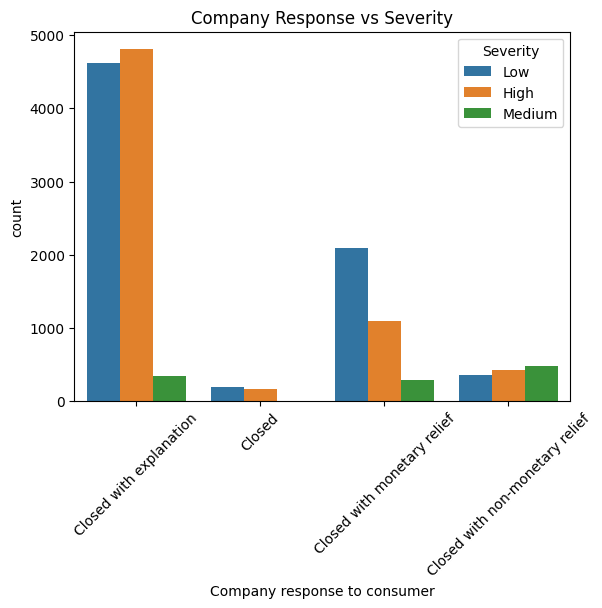

In [ ]:
sns.countplot(x='Company response to consumer', hue='Severity', data=df)
plt.xticks(rotation=45)
plt.title("Company Response vs Severity")
plt.show()


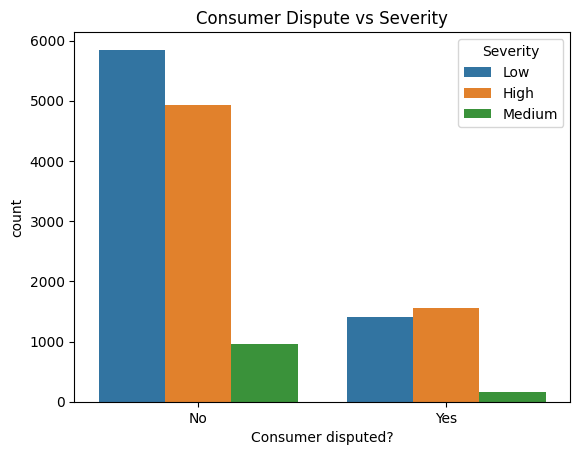

In [ ]:
sns.countplot(x='Consumer disputed?', hue='Severity', data=df)
plt.title("Consumer Dispute vs Severity")
plt.show()


In [ ]:
# Drop rows where complaint narrative has fewer than 15 words
df = df[df["Consumer complaint narrative"].astype(str).apply(lambda x: len(x.split()) >= 15)]

# Reset index after dropping
df.reset_index(drop=True, inplace=True)



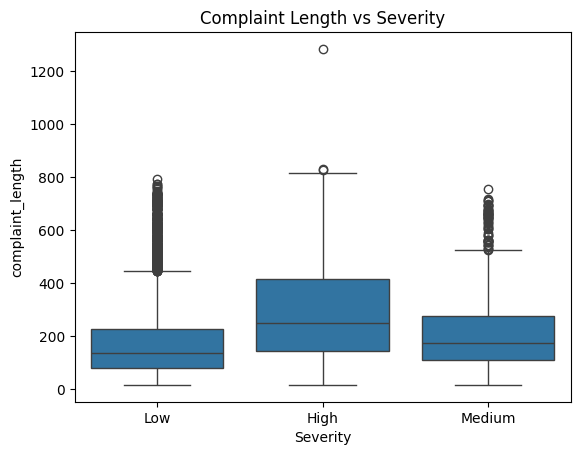

In [ ]:
df['complaint_length'] = df['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='Severity', y='complaint_length', data=df)
plt.title("Complaint Length vs Severity")
plt.show()


In [ ]:
import pandas as pd

# Compute complaint length
df['complaint_length'] = df['Consumer complaint narrative'].astype(str).apply(lambda x: len(x.split()))

# Function to remove outliers inside each severity group
def remove_outliers(group):
    Q1 = group['complaint_length'].quantile(0.25)
    Q3 = group['complaint_length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only non-outlier rows
    return group[(group['complaint_length'] >= lower_bound) &
                 (group['complaint_length'] <= upper_bound)]

# Apply per severity category
df1 = df.groupby('Severity', group_keys=False).apply(remove_outliers)

df1.reset_index(drop=True, inplace=True)

print("Original rows:", len(df))
print("After removing outliers:", len(df1))


Original rows: 14751
After removing outliers: 14278


/tmp/ipython-input-2715798061.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df.groupby('Severity', group_keys=False).apply(remove_outliers)


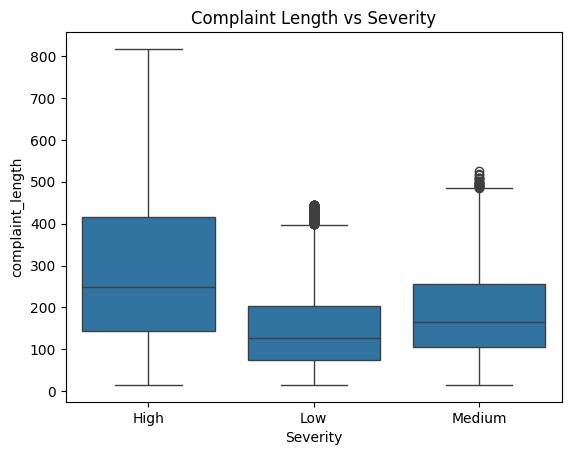

In [ ]:
df1['complaint_length'] = df1['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='Severity', y='complaint_length', data=df1)
plt.title("Complaint Length vs Severity")
plt.show()

In [ ]:
df1.groupby("Severity")["complaint_length"].describe()


,count,mean,std,min,25%,50%,75%,max
Severity,,,,,,,,
High,6465.0,297.686775,194.107687,15.0,144.0,249.0,415.00,817.0
Low,6743.0,150.245588,97.005360,15.0,75.0,127.0,204.00,445.0
Medium,1070.0,192.713084,113.460051,15.0,105.0,165.0,256.75,525.0


In [ ]:
df.head()

,Sub-product,Issue,Consumer complaint narrative,Company response to consumer,Timely response?,Consumer disputed?,Severity,Severity_label,complaint_length
0,Checking account,Using a debit or ATM card,I have an account in Texas. Citi sent me a new...,Closed with explanation,Yes,No,Low,0,172
1,Checking account,"Account opening, closing, or management",On XXXX XXXX 2015 I called Santander bank and ...,Closed,Yes,No,High,2,447
2,Checking account,Using a debit or ATM card,There was an erroneous charge on my TD bank ac...,Closed with monetary relief,Yes,No,Low,0,199
3,Checking account,"Account opening, closing, or management","Dear Sir/Madam, Around six months ago I opened...",Closed with non-monetary relief,Yes,No,Medium,1,168
4,Checking account,Problems caused by my funds being low,I had a check bounce due to insufficient funds...,Closed with explanation,Yes,No,Low,0,242


In [ ]:
df1.head(15)

,Sub-product,Issue,Consumer complaint narrative,Company response to consumer,Timely response?,Consumer disputed?,Severity,Severity_label,complaint_length
0,Checking account,"Account opening, closing, or management",On XXXX XXXX 2015 I called Santander bank and ...,Closed,Yes,No,High,2,447
1,Other bank product/service,Deposits and withdrawals,I was applying for a XXXX job on XXXX on XXXX ...,Closed with explanation,Yes,No,High,2,648
2,Other bank product/service,"Making/receiving payments, sending money","Back on 2005, We refinanced our home loan with...",Closed with explanation,Yes,No,High,2,121
3,Checking account,Deposits and withdrawals,For the past year I have been having trouble w...,Closed with explanation,Yes,No,High,2,104
4,Checking account,"Account opening, closing, or management",According to the Bank of America FICO score re...,Closed with explanation,Yes,Yes,High,2,144
5,Checking account,"Account opening, closing, or management",I ordered new Bank of America checks online in...,Closed with explanation,Yes,No,High,2,289
6,Other bank product/service,Deposits and withdrawals,"I sold an item on ebay, in my description I sp...",Closed with explanation,Yes,Yes,High,2,90
7,Checking account,Deposits and withdrawals,My husband wrote a personal check from his XXX...,Closed with explanation,No,No,High,2,165
8,Other bank product/service,Using a debit or ATM card,I have a flexible medical spending account thr...,Closed with monetary relief,Yes,No,High,2,145
9,Checking account,"Account opening, closing, or management",I have been a member of Pentagon Federal Credi...,Closed with explanation,Yes,No,High,2,595


# NLP Models

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping





In [ ]:
import pandas as pd
import re

# 1️⃣ Copy the original DataFrame
df1 = df1.copy()

# 2️⃣ Define preprocessing function
def preprocess_text(text):
    text = str(text).lower()                       # lowercase
    text = re.sub(r'\s+', ' ', text).strip()       # remove extra whitespace/newlines
    text = re.sub(r'<.*?>', '', text)              # remove HTML tags if any
    return text

# 3️⃣ Apply preprocessing to the narrative column
df1['cleaned_narrative'] = df1['Consumer complaint narrative'].apply(preprocess_text)

# 4️⃣ Optional: check the result
df1[['Consumer complaint narrative','cleaned_narrative']].head()


,Consumer complaint narrative,cleaned_narrative
0,On XXXX XXXX 2015 I called Santander bank and ...,on xxxx xxxx 2015 i called santander bank and ...
1,I was applying for a XXXX job on XXXX on XXXX ...,i was applying for a xxxx job on xxxx on xxxx ...
2,"Back on 2005, We refinanced our home loan with...","back on 2005, we refinanced our home loan with..."
3,For the past year I have been having trouble w...,for the past year i have been having trouble w...
4,According to the Bank of America FICO score re...,according to the bank of america fico score re...


In [ ]:
# Replace old narrative column with preprocessed one
df1['Consumer complaint narrative'] = df1['cleaned_narrative']

# Optional: drop the temporary 'cleaned_narrative' column
df1.drop(columns=['cleaned_narrative'], inplace=True)



In [ ]:
# Check the result
df1.head(15)


,Sub-product,Issue,Consumer complaint narrative,Company response to consumer,Timely response?,Consumer disputed?,Severity,Severity_label,complaint_length
0,Checking account,"Account opening, closing, or management",on xxxx xxxx 2015 i called santander bank and ...,Closed,Yes,No,High,2,447
1,Other bank product/service,Deposits and withdrawals,i was applying for a xxxx job on xxxx on xxxx ...,Closed with explanation,Yes,No,High,2,648
2,Other bank product/service,"Making/receiving payments, sending money","back on 2005, we refinanced our home loan with...",Closed with explanation,Yes,No,High,2,121
3,Checking account,Deposits and withdrawals,for the past year i have been having trouble w...,Closed with explanation,Yes,No,High,2,104
4,Checking account,"Account opening, closing, or management",according to the bank of america fico score re...,Closed with explanation,Yes,Yes,High,2,144
5,Checking account,"Account opening, closing, or management",i ordered new bank of america checks online in...,Closed with explanation,Yes,No,High,2,289
6,Other bank product/service,Deposits and withdrawals,"i sold an item on ebay, in my description i sp...",Closed with explanation,Yes,Yes,High,2,90
7,Checking account,Deposits and withdrawals,my husband wrote a personal check from his xxx...,Closed with explanation,No,No,High,2,165
8,Other bank product/service,Using a debit or ATM card,i have a flexible medical spending account thr...,Closed with monetary relief,Yes,No,High,2,145
9,Checking account,"Account opening, closing, or management",i have been a member of pentagon federal credi...,Closed with explanation,Yes,No,High,2,595


In [ ]:
df1.dtypes

,0
Sub-product,object
Issue,object
Consumer complaint narrative,object
Company response to consumer,object
Timely response?,object
Consumer disputed?,object
Severity,object
Severity_label,int64
complaint_length,int64


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Features and labels
X = df1['Consumer complaint narrative']
y = df1['Severity_label']  # 0=Low, 1=Medium, 2=High

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split training into train and validation
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Convert to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_main, y_train_main))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle + batch
batch_size = 32

train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


##GlobalAveragePooling1D

In [ ]:
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(
    max_tokens=20000,
    output_sequence_length=200,
    standardize='lower_and_strip_punctuation'
)

vectorizer.adapt(X_train)



In [ ]:
# Define max_tokens before using it
max_tokens = 20000  # or whatever number you want

embedding_dim = 100

model = Sequential([
    vectorizer,  # make sure vectorizer = TextVectorization(...) is already defined
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

# Explicit model build
model.build(input_shape=(None,))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,006,659 (7.65 MB)

 Trainable params: 2,006,659 (7.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)





Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6885 - loss: 0.7445 - val_accuracy: 0.8617 - val_loss: 0.3072
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9054 - loss: 0.2405 - val_accuracy: 0.8902 - val_loss: 0.2629
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9345 - loss: 0.1778 - val_accuracy: 0.8932 - val_loss: 0.2708
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9500 - loss: 0.1344 - val_accuracy: 0.8906 - val_loss: 0.2984
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9639 - loss: 0.1081 - val_accuracy: 0.8875 - val_loss: 0.3196
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9790 - loss: 0.0732 - val_accuracy: 0.8801 - val_loss: 0.3578
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9855 - loss: 0.0557 - val_accuracy: 0.8713 - val_loss: 0.4329
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9916 - loss: 0.0367 - val_accuracy

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8788 - loss: 0.5556
Test Accuracy: 0.87


##LSTM


In [ ]:
max_tokens = 30000   # larger vocabulary
max_len = 300        # longer sequences

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=max_len
)

# Fit vectorizer on training data
vectorizer.adapt(X_train_main.tolist())


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_main),
    y=y_train_main
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.7027380403014921), 1: np.float64(4.338556505223172), 2: np.float64(0.7426643907989922)}


In [ ]:
embedding_dim = 200

model = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True),
    LSTM(64, return_sequences=False),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)
# Build the model by specifying input shape (batch_size can be None)
model.build(input_shape=(None,))  # for text input


model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 300)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 300, 200)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,084,611 (23.21 MB)

 Trainable params: 6,084,611 (23.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)


Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5165 - loss: 0.9393 - val_accuracy: 0.8530 - val_loss: 0.4071
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8344 - loss: 0.3533 - val_accuracy: 0.7247 - val_loss: 0.5862
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8122 - loss: 0.3734 - val_accuracy: 0.8249 - val_loss: 0.5231
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9018 - loss: 0.2380 - val_accuracy: 0.8656 - val_loss: 0.3737
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9293 - loss: 0.1789 - val_accuracy: 0.8061 - val_loss: 0.5157
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9334 - loss: 0.1598 - val_accuracy: 0.8403 - val_loss: 0.4975
Epoch 7/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9383 - loss: 0.1458 - val_accuracy: 0.7877 - val_loss: 0.6599


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8671 - loss: 0.3744
Test Accuracy: 0.86


##LSTM 2

In [ ]:
# Text Vectorization
max_tokens = 10000   # reduce vocab size for faster training
max_len = 100        # reduce sequence length

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=max_len
)
vectorizer.adapt(X_train_main.tolist())

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_main),
    y=y_train_main
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.7027380403014921), 1: np.float64(4.338556505223172), 2: np.float64(0.7426643907989922)}


In [ ]:
# Build LSTM model

embedding_dim = 100  # reduced embedding size

model = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),  # LSTM with dropout
    Dense(64, activation='relu'),
    Dropout(0.3),  # Dense dropout for regularization
    Dense(3, activation='softmax')
])

# Compile model with smaller learning rate
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)
# Build the model by specifying input shape (sequence of strings)
model.build(input_shape=(None,))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_4            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,046,595 (3.99 MB)

 Trainable params: 1,046,595 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)


Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 124s 417ms/step - accuracy: 0.4679 - loss: 0.9716 - val_accuracy: 0.6228 - val_loss: 0.7273
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 121s 422ms/step - accuracy: 0.5898 - loss: 0.6156 - val_accuracy: 0.7510 - val_loss: 0.5910
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 119s 416ms/step - accuracy: 0.7415 - loss: 0.4834 - val_accuracy: 0.7580 - val_loss: 0.5305
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 142s 417ms/step - accuracy: 0.7913 - loss: 0.3960 - val_accuracy: 0.7562 - val_loss: 0.5415
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 141s 414ms/step - accuracy: 0.8165 - loss: 0.3830 - val_accuracy: 0.7663 - val_loss: 0.5337
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 142s 416ms/step - accuracy: 0.8443 - loss: 0.3231 - val_accuracy: 0.7571 - val_loss: 0.5650


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Test Accuracy:", accuracy)


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.7813 - loss: 0.5139
Test Accuracy: 0.776260495185852


##Bidirectional LSTM

In [ ]:
# Text Vectorization

max_tokens = 20000
max_len = 200

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=max_len
)
vectorizer.adapt(X_train_main.tolist())

In [ ]:

# Compute Class Weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_main),
    y=y_train_main
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.7027380403014921), 1: np.float64(4.338556505223172), 2: np.float64(0.7426643907989922)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras import regularizers


embedding_dim = 100

model = Sequential([
    vectorizer,

    Embedding(
        input_dim=max_tokens,
        output_dim=embedding_dim,
        mask_zero=True
    ),

    # Much faster regularization than recurrent_dropout
    SpatialDropout1D(0.2),

    Bidirectional(LSTM(
        48,      # reduced units
        return_sequences=False,
        dropout=0.2  # only dropout on inputs, faster
    )),

    Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    Dropout(0.3),  # slightly lower dropout

    Dense(3, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # slightly higher LR
    metrics=['accuracy']
)

# Build the model to see summary
model.build(input_shape=(None,))
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 200, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 96)             │        57,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,063,619 (7.87 MB)

 Trainable params: 2,063,619 (7.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5427 - loss: 0.9302 - val_accuracy: 0.8363 - val_loss: 0.4599
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8616 - loss: 0.3571 - val_accuracy: 0.8801 - val_loss: 0.3354
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9127 - loss: 0.2304 - val_accuracy: 0.8551 - val_loss: 0.4575
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9330 - loss: 0.1748 - val_accuracy: 0.8543 - val_loss: 0.5643
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9460 - loss: 0.1520 - val_accuracy: 0.8770 - val_loss: 0.3626


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Test Accuracy:", accuracy)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8806 - loss: 0.3272
Test Accuracy: 0.8799019455909729


##1CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout
)

In [ ]:

# Build CNN model
embedding_dim = 100

model = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dim),

    # 1D Convolution layer
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),

    # Global Max Pooling
    GlobalMaxPooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

model.build(input_shape=(None,))
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,027 (7.94 MB)

 Trainable params: 2,081,027 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)



Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5137 - loss: 0.9023 - val_accuracy: 0.8188 - val_loss: 0.4195
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8279 - loss: 0.3233 - val_accuracy: 0.8368 - val_loss: 0.3714
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8850 - loss: 0.2149 - val_accuracy: 0.8595 - val_loss: 0.3316
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9414 - loss: 0.1249 - val_accuracy: 0.8670 - val_loss: 0.3281
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9822 - loss: 0.0527 - val_accuracy: 0.8696 - val_loss: 0.3459
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9962 - loss: 0.0205 - val_accuracy: 0.8683 - val_loss: 0.3807
Epoch 7/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9994 - loss: 0.0078 - val_accuracy: 0.8678 - val_loss: 0.3997


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Test Accuracy:", accuracy)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8791 - loss: 0.2993
Test Accuracy: 0.8697478771209717


##Multi cnn

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    TextVectorization, Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout, Concatenate, Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Multi-Channel CNN Model
embedding_dim = 100
filters = 64  # reduced from 128 → prevents overfitting

input_layer = Input(shape=(1,), dtype=tf.string)

# Text vectorizer
x = vectorizer(input_layer)

# Embedding
x = Embedding(input_dim=max_tokens, output_dim=embedding_dim)(x)

# ------- CNN Branch 1 -------
c1 = Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same',
            kernel_regularizer=l2(0.001))(x)
p1 = GlobalMaxPooling1D()(c1)

# ------- CNN Branch 2 -------
c2 = Conv1D(filters=filters, kernel_size=4, activation='relu', padding='same',
            kernel_regularizer=l2(0.001))(x)
p2 = GlobalMaxPooling1D()(c2)

# ------- CNN Branch 3 -------
c3 = Conv1D(filters=filters, kernel_size=5, activation='relu', padding='same',
            kernel_regularizer=l2(0.001))(x)
p3 = GlobalMaxPooling1D()(c3)

# Concatenate all branches
merged = Concatenate()([p1, p2, p3])

# Dense + Regularization
dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(merged)
dense = Dropout(0.5)(dense)

output = Dense(3, activation='softmax')(dense)

model = Model(inputs=input_layer, outputs=output)

# Compile
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    metrics=["accuracy"]
)

model.summary()

# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 200)       │          0 │ input_layer_8[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 200, 100)  │  2,000,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 200, 64)   │     19,264 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 200, 64)   │     25,664 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 200, 64)   │     32,064 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 3)         │        195 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,089,539 (7.97 MB)

 Trainable params: 2,089,539 (7.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5023 - loss: 1.1387 - val_accuracy: 0.7947 - val_loss: 0.6055
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8065 - loss: 0.5183 - val_accuracy: 0.8433 - val_loss: 0.4914
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8543 - loss: 0.3925 - val_accuracy: 0.8521 - val_loss: 0.4529
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8937 - loss: 0.3175 - val_accuracy: 0.8626 - val_loss: 0.4246
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9355 - loss: 0.2424 - val_accuracy: 0.8630 - val_loss: 0.4329
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9647 - loss: 0.1862 - val_accuracy: 0.8525 - val_loss: 0.4895
Epoch 7/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9794 - loss: 0.1484 - val_accuracy: 0.8473 - val_loss: 0.4904


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Test Accuracy:", accuracy)

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8612 - loss: 0.4040
Test Accuracy: 0.8595938086509705


## Bi-LSTM + Attention Network

In [ ]:
#TEXT VECTORIZATION
max_tokens = 30000
seq_len = 400

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len
)

vectorizer.adapt(X_train_main.tolist())


#CLASS WEIGHTS (for imbalanced labels)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_main),
    y=y_train_main
)

class_weights = dict(enumerate(class_weights))
print("CLASS WEIGHTS:", class_weights)


# FIXED ATTENTION LAYER
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.score_dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        score = self.score_dense(inputs)           # (batch, seq_len, 1)
        weights = tf.nn.softmax(score, axis=1)     # attention weights
        context = tf.reduce_sum(weights * inputs, axis=1)
        return context


# BILSTM + ATTENTION MODEL
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = tf.keras.layers.Embedding(max_tokens, 128)(x)

x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(x)

x = AttentionLayer()(x)

x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()



#TRAINING
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)

CLASS WEIGHTS: {0: np.float64(0.7027380403014921), 1: np.float64(4.338556505223172), 2: np.float64(0.7426643907989922)}


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_8            │ (None, 400)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 400, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 400, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_2               │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,947,396 (15.06 MB)

 Trainable params: 3,947,396 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.6073 - loss: 0.9883 - val_accuracy: 0.8280 - val_loss: 0.4066
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8656 - loss: 0.3008 - val_accuracy: 0.8757 - val_loss: 0.3059
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9118 - loss: 0.1987 - val_accuracy: 0.8972 - val_loss: 0.2539
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9424 - loss: 0.1314 - val_accuracy: 0.9090 - val_loss: 0.2589
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9603 - loss: 0.1008 - val_accuracy: 0.9037 - val_loss: 0.2759
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9702 - loss: 0.0724 - val_accuracy: 0.9015 - val_loss: 0.2838


In [ ]:

loss, acc = model.evaluate(test_ds)
print(f"TEST ACCURACY = {acc:.4f}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9037 - loss: 0.2518
TEST ACCURACY = 0.9023


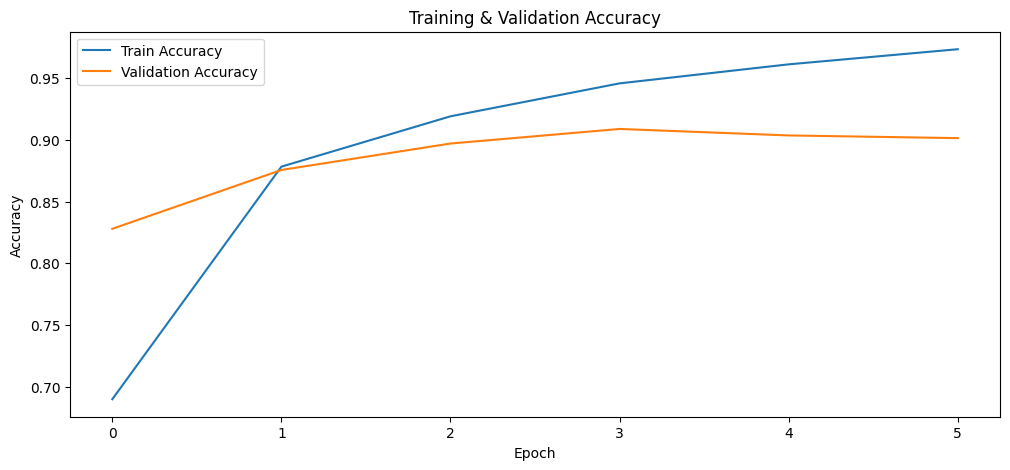

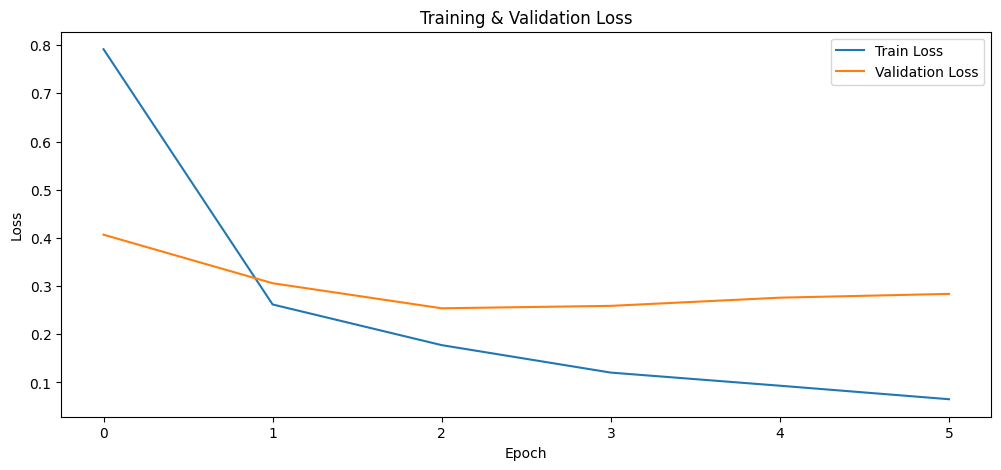

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


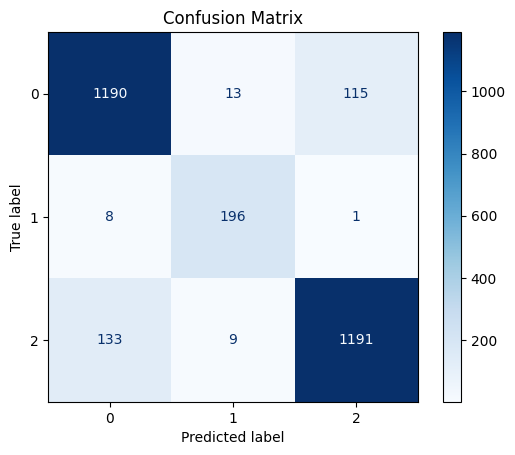

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred_probs = model.predict(test_ds)
y_pred = y_pred_probs.argmax(axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


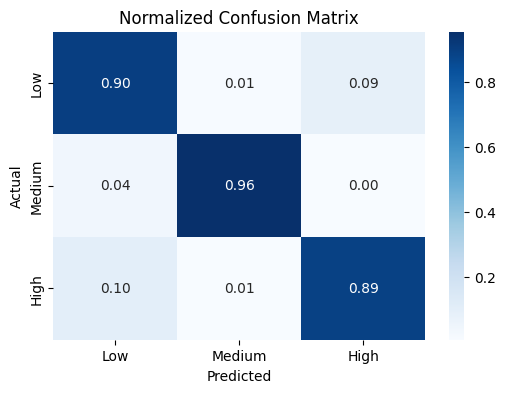

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f",
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Low","Medium","High"]))


              precision    recall  f1-score   support

         Low       0.89      0.90      0.90      1318
      Medium       0.90      0.96      0.93       205
        High       0.91      0.89      0.90      1333

    accuracy                           0.90      2856
   macro avg       0.90      0.92      0.91      2856
weighted avg       0.90      0.90      0.90      2856



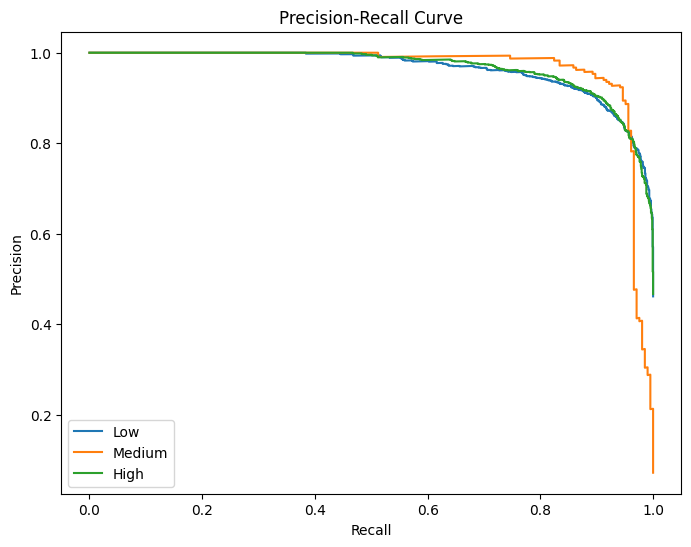

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y_true, classes=[0,1,2])

plt.figure(figsize=(8,6))
for i, cls in enumerate(["Low","Medium","High"]):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=cls)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


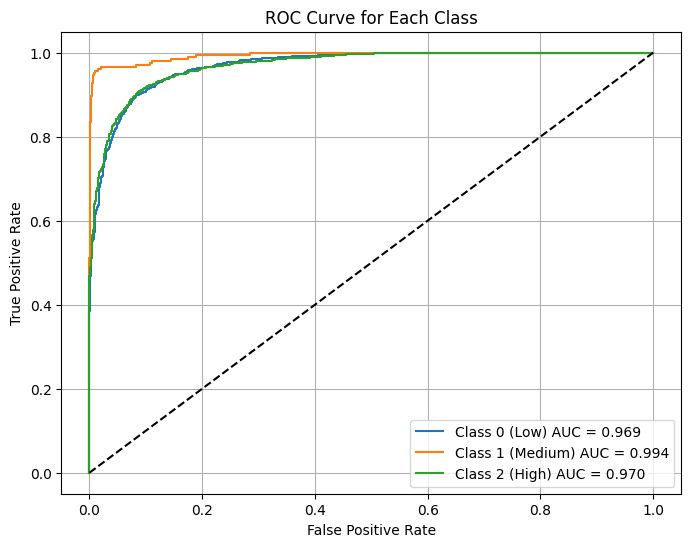

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Predicted probabilities (already computed)
# y_pred_probs = model.predict(test_ds)

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))

class_names = ["Low", "Medium", "High"]

for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} ({class_names[i]}) AUC = {roc_auc:.3f}")

# Diagonal line
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend()
plt.grid(True)
plt.show()


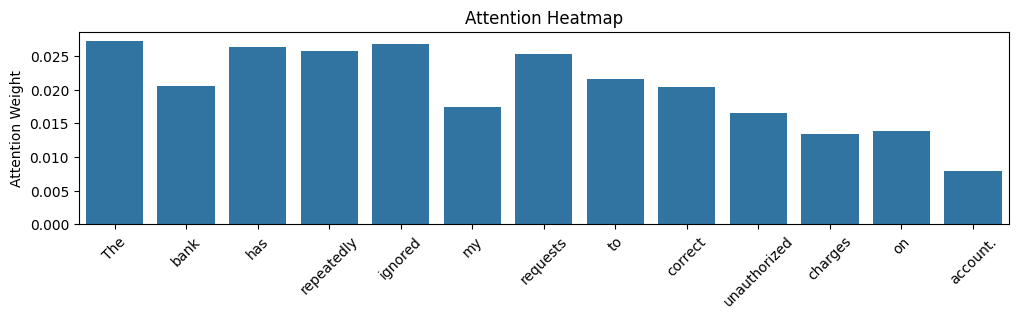

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# ---- FUNCTION: Extract Attention Weights ----
def get_attention_words_and_weights(text, model, vectorizer, top_k=None):
    tokenized = vectorizer([text])  # (1, seq_len)

    embedding_layer = model.layers[2]
    bilstm_layer    = model.layers[3]
    attention_layer = model.layers[4]

    embedded = embedding_layer(tokenized)
    lstm_out = bilstm_layer(embedded)

    score = attention_layer.score_dense(lstm_out)
    weights = tf.nn.softmax(score, axis=1).numpy().flatten()

    words = text.split()

    weights = weights[:len(words)]

    if top_k:
        idx = np.argsort(weights)[-top_k:]
        words = [words[i] for i in idx]
        weights = [weights[i] for i in idx]

    return words, weights


# ---- FUNCTION: Plot Attention Heatmap (NO CI LINE) ----
def plot_attention_heatmap(text, model, vectorizer, top_k=None):
    words, weights = get_attention_words_and_weights(text, model, vectorizer, top_k)

    plt.figure(figsize=(12, 2.5))

    # 👇 REMOVE the vertical CI line by disabling error bars
    sns.barplot(x=words, y=weights, errorbar=None)   # For Seaborn 0.12+
    # If older seaborn: sns.barplot(x=words, y=weights, ci=None)

    plt.title("Attention Heatmap")
    plt.ylabel("Attention Weight")
    plt.xticks(rotation=45)
    plt.show()


# ---- Example Usage ----
sample_text = "The bank has repeatedly ignored my requests to correct unauthorized charges on my account."
plot_attention_heatmap(sample_text, model, vectorizer)


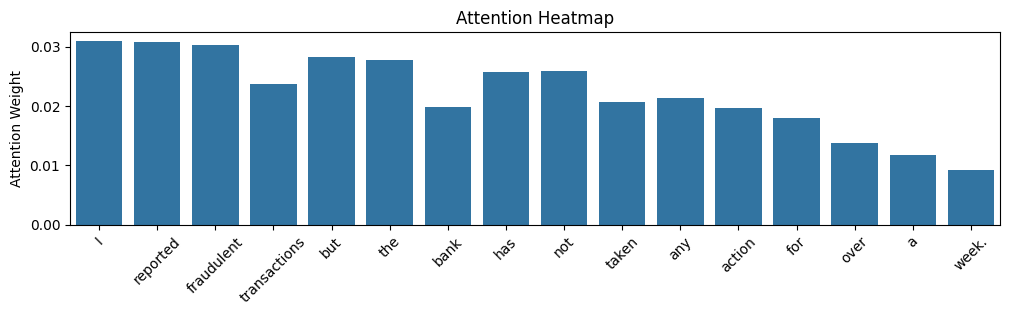

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# ---- FUNCTION: Extract Attention Weights ----
def get_attention_words_and_weights(text, model, vectorizer, top_k=None):
    tokenized = vectorizer([text])  # (1, seq_len)

    embedding_layer = model.layers[2]
    bilstm_layer    = model.layers[3]
    attention_layer = model.layers[4]

    embedded = embedding_layer(tokenized)
    lstm_out = bilstm_layer(embedded)

    score = attention_layer.score_dense(lstm_out)
    weights = tf.nn.softmax(score, axis=1).numpy().flatten()

    words = text.split()

    weights = weights[:len(words)]

    if top_k:
        idx = np.argsort(weights)[-top_k:]
        words = [words[i] for i in idx]
        weights = [weights[i] for i in idx]

    return words, weights


# ---- FUNCTION: Plot Attention Heatmap (NO CI LINE) ----
def plot_attention_heatmap(text, model, vectorizer, top_k=None):
    words, weights = get_attention_words_and_weights(text, model, vectorizer, top_k)

    plt.figure(figsize=(12, 2.5))

    # 👇 REMOVE the vertical CI line by disabling error bars
    sns.barplot(x=words, y=weights, errorbar=None)   # For Seaborn 0.12+
    # If older seaborn: sns.barplot(x=words, y=weights, ci=None)

    plt.title("Attention Heatmap")
    plt.ylabel("Attention Weight")
    plt.xticks(rotation=45)
    plt.show()


# ---- Example Usage ----
sample_text = "I reported fraudulent transactions but the bank has not taken any action for over a week."
plot_attention_heatmap(sample_text, model, vectorizer)

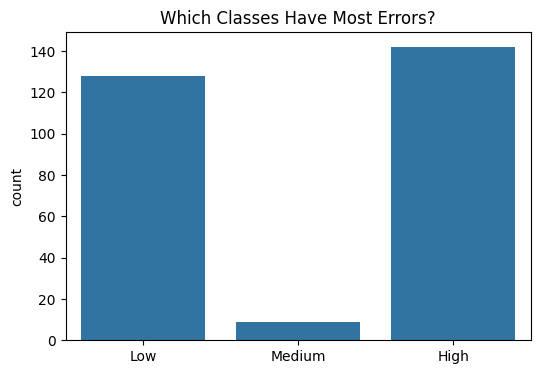

In [ ]:
errors = y_true != y_pred

plt.figure(figsize=(6,4))
sns.countplot(x=y_true[errors])
plt.xticks([0,1,2], ["Low","Medium","High"])
plt.title("Which Classes Have Most Errors?")
plt.show()


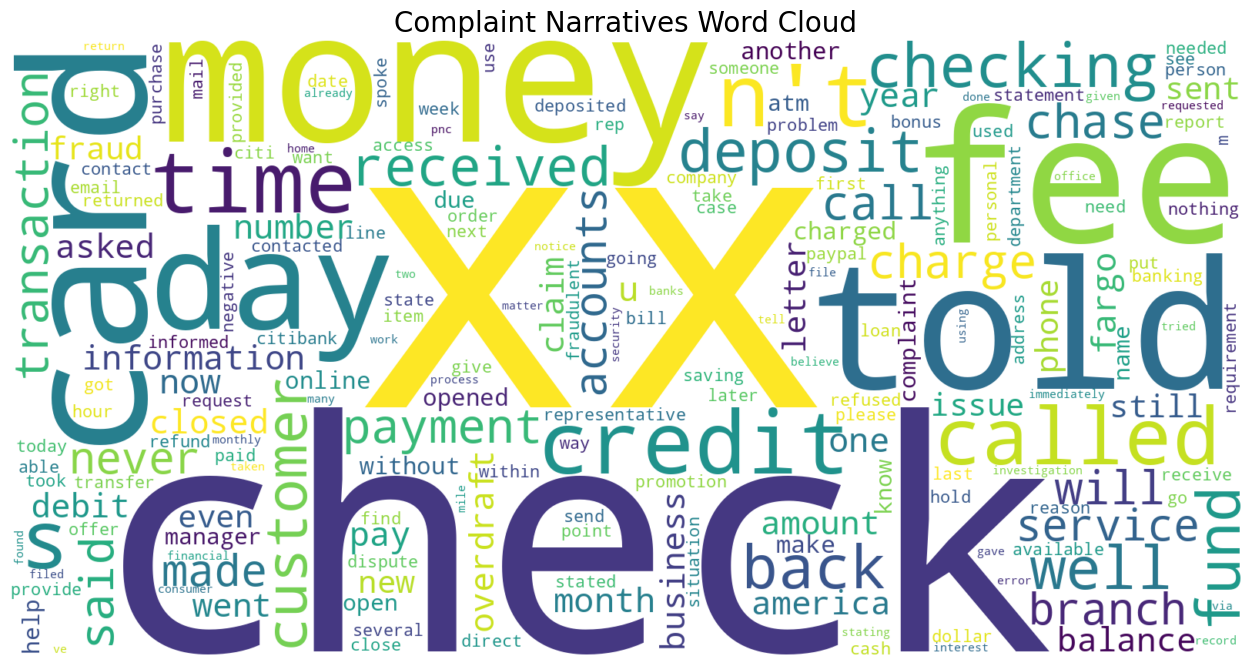

In [ ]:

# Extract raw text strings from test_ds
list_of_texts = []

for batch_x, batch_y in test_ds:
    for t in batch_x.numpy():
        list_of_texts.append(t.decode("utf-8"))

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generate_wordcloud(text_list, title="Word Cloud"):
    # Join all text
    full_text = " ".join(text_list)

    # Add default + custom stopwords
    stopwords = set(STOPWORDS)
    stopwords.update(["xxxx", "xxxxxx", "bank", "account"])  # optional remove common noisy words

    # Create word cloud
    wc = WordCloud(
        width=1600,
        height=800,
        stopwords=stopwords,
        background_color="white",
        max_words=200,
        collocations=False  # prevents duplicate bigrams with lines
    ).generate(full_text)

    # Plot
    plt.figure(figsize=(16, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

# Run it
generate_wordcloud(list_of_texts, title="Complaint Narratives Word Cloud")



In [ ]:
# Save model
model.save("severity_model.keras")

# Zip it
!zip -r severity_model.zip severity_model.keras

# Download
from google.colab import files
files.download("severity_model.zip")


  adding: severity_model.keras (deflated 25%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>